In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
import math

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 100%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [3]:
def show_image(img):
    imPlot1 = img[:,:,::-1]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.rcParams["figure.figsize"] = (25, 9)
    plt.imshow(imPlot1)
    
def show_gimage(img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')
    
def plotTwo(img1, img2):
    imPlot1 = img1[:,:,::-1]
    imPlot2 = img2[:,:,::-1]

    width, height = imPlot1.shape[:2]

    fig = plt.figure(figsize=(width/10, height/10))

    columns = 2
    rows = 1

    fig.add_subplot(rows, columns, 1)
    plt.imshow(imPlot1)

    fig.add_subplot(rows, columns, 2)
    plt.imshow(imPlot2)
    
    plt.show()

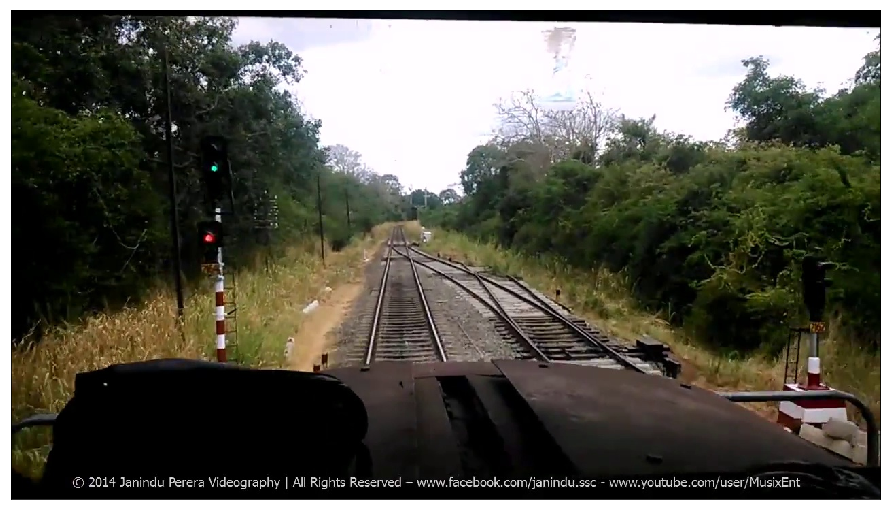

In [26]:
img = cv.imread('../images/video-x/frame24.jpg')
show_image(img)

(720, 1280, 3)


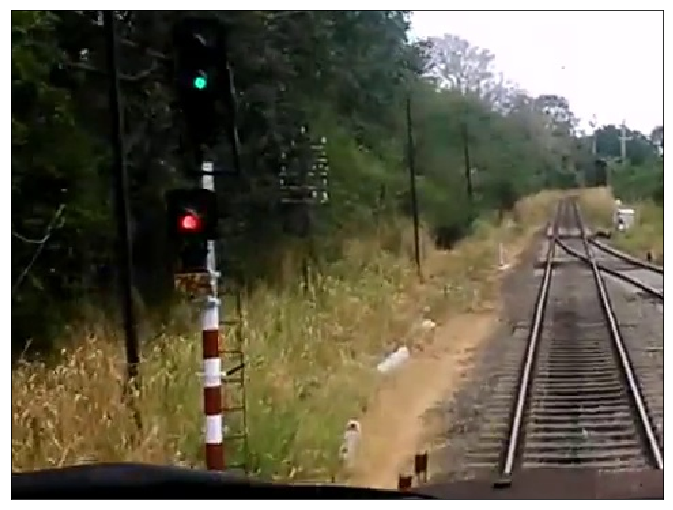

In [27]:
# Take only left
h,w,c = img.shape
print(img.shape)
cropped_img = img[math.floor(h/4):math.floor(h*3/4)]
cropped_img = cropped_img[:,math.floor(w/8):math.floor(w/2)]


show_image(cropped_img)

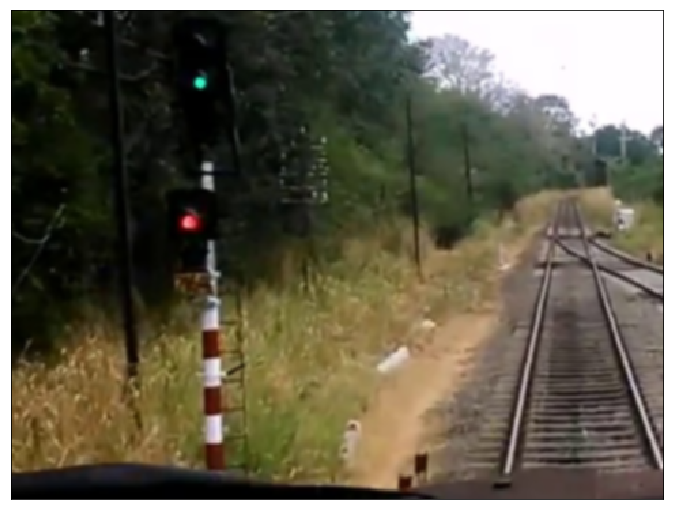

In [28]:
# Apply gaussian Blur
blured = cv.GaussianBlur(cropped_img, (5,5),0 )
show_image(blured)

6it [00:00, 1498.50it/s]


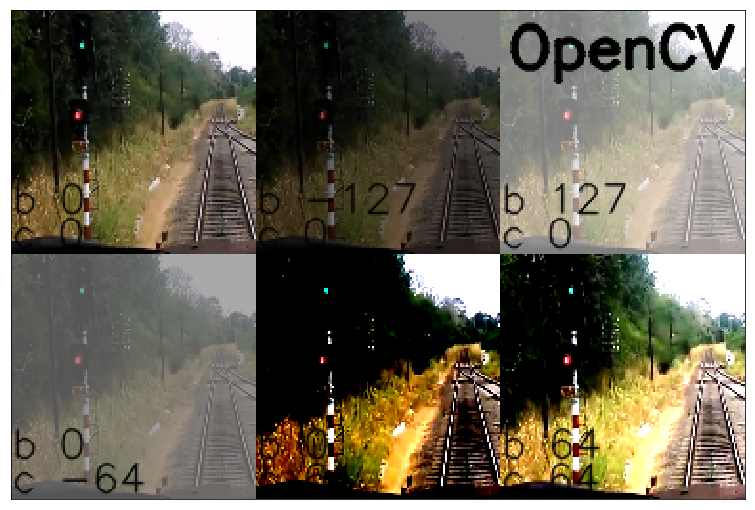

In [29]:
s = 128
img_copy = cv.resize(cropped_img, (s,s), 0, 0, cv.INTER_AREA)

def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):

    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow

        buf = cv.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()

    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)

        buf = cv.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf


font = cv.FONT_HERSHEY_SIMPLEX
fcolor = (0,0,0)

blist = [0, -127, 127,   0,  0, 64] # list of brightness values
clist = [0,    0,   0, -64, 64, 64] # list of contrast values


out = np.zeros((s*2, s*3, 3), dtype = np.uint8)

for i, b in tqdm(enumerate(blist)):
    c = clist[i]   
    row = s*int(i/3)
    col = s*(i%3)   

    out[row:row+s, col:col+s] = apply_brightness_contrast(img_copy, b, c)
    msg = 'b %d' % b
    cv.putText(out,msg,(col,row+s-22), font, .7, fcolor,1,cv.LINE_AA)
    msg = 'c %d' % c
    cv.putText(out,msg,(col,row+s-4), font, .7, fcolor,1,cv.LINE_AA)

    cv.putText(out, 'OpenCV',(260,30), font, 1.0, fcolor,2,cv.LINE_AA)

show_image(out)

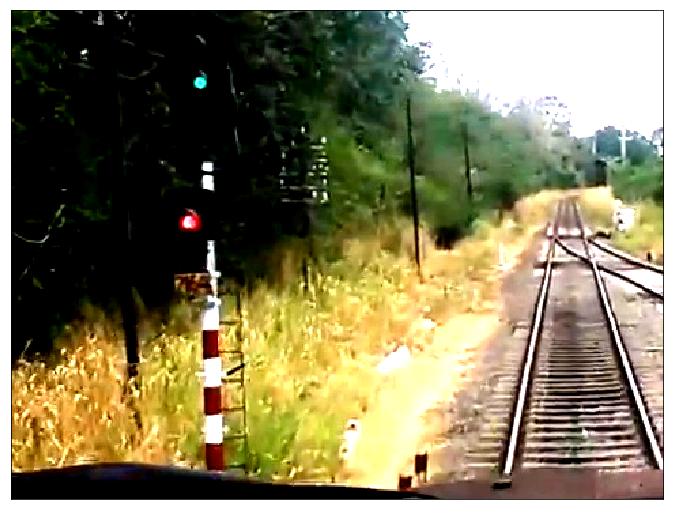

In [30]:
bc_img = apply_brightness_contrast(cropped_img,64,64)
show_image(bc_img)

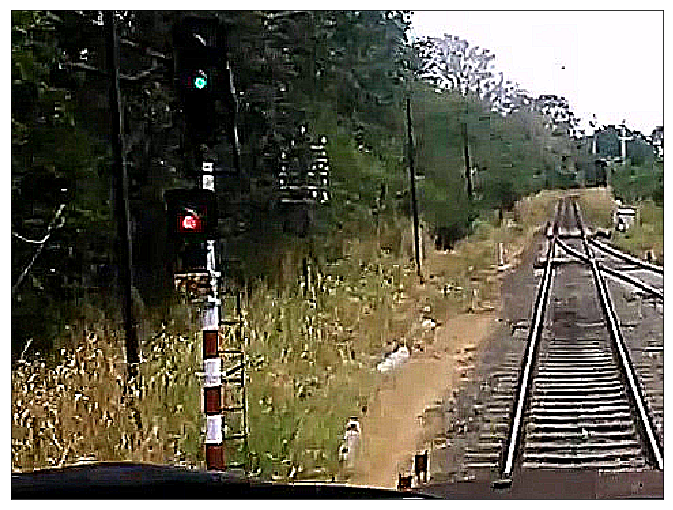

In [32]:
kernel = np.array([[-1,-1,-1], 
                   [-1, 9,-1],
                   [-1,-1,-1]])
sharpened = cv.filter2D(cropped_img, -1, kernel) # applying the sharpening kernel to the input image & displaying it.
show_image(sharpened)

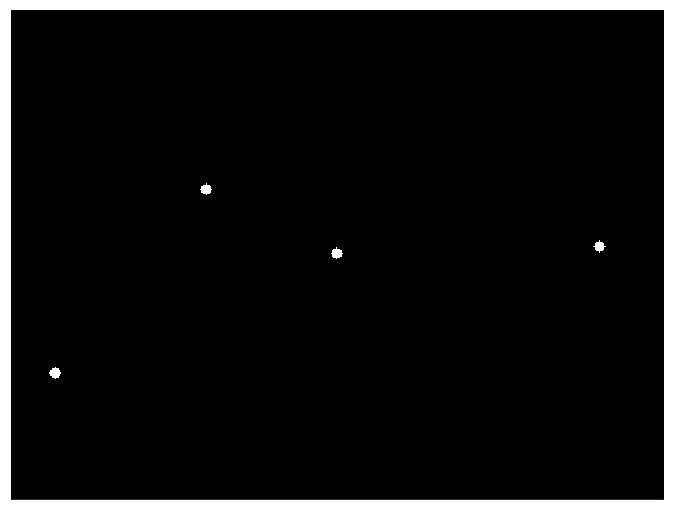

In [33]:
import cv2 
import numpy as np

image = cropped_img

#  constants
BINARY_THRESHOLD = 180
CONNECTIVITY = 4
DRAW_CIRCLE_RADIUS = 4

#  convert to gray
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#  extract edges
binary_image = cv2.Laplacian(gray_image, cv2.CV_8UC1)

#  fill in the holes between edges with dilation
dilated_image = cv2.dilate(binary_image, np.ones((5, 5)))

#  threshold the black/ non-black areas
_, thresh = cv2.threshold(dilated_image, BINARY_THRESHOLD, 255, cv2.THRESH_BINARY)

#  find connected components
components = cv2.connectedComponentsWithStats(thresh, CONNECTIVITY, cv2.CV_32S)

#  draw circles around center of components
#see connectedComponentsWithStats function for attributes of components variable
centers = components[3]
for center in centers:
    cv2.circle(thresh, (int(center[0]), int(center[1])), DRAW_CIRCLE_RADIUS, (255), thickness=-1)

#cv2.imwrite("res.png", thresh)
show_gimage(thresh)

In [34]:
# import cv2
# import numpy as np

# img = cv2.imread('../images/video-x/frame24.jpg', 0)
# img = cv2.medianBlur(img,5)
# cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

# circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,20,
#                             param1=50,param2=30,minRadius=0,maxRadius=0)

# circles = np.uint16(np.around(circles))
# for i in circles[0,:]:
#     # draw the outer circle
#     cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
#     # draw the center of the circle
#     cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

# show_image(cimg)

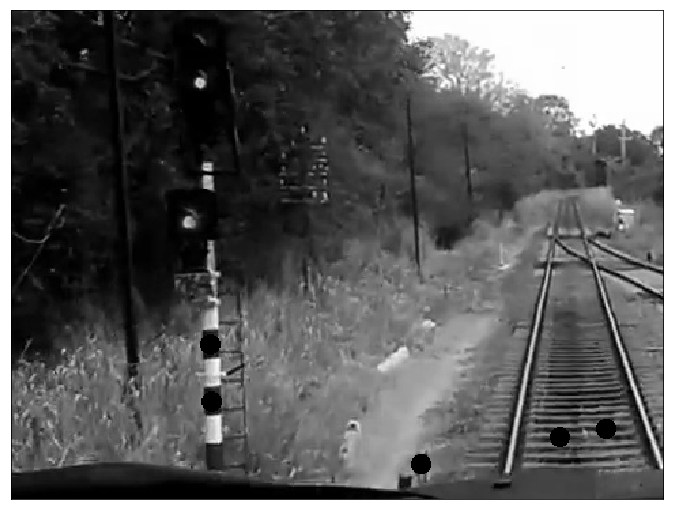

In [35]:
import cv2
import numpy as np;
 
# Read image
im = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
# Set up the detector with default parameters.
params = cv2.SimpleBlobDetector_Params()
# Change thresholds
params.minThreshold = 10;
params.maxThreshold = 1200;
 
# Filter by Area.
params.filterByArea = True
params.minArea = 100
 
# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.1
 
# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.87
 
# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.01
 

 
# Detect blobs.
detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(im)

def draw_keypoints(vis, keypoints, color = (0, 255, 255)):
    objects = []
    for k in keypoints:
        (x,y)=k.pt
        x=int(round(x))
        y=int(round(y))        
        cv2.circle(vis,(x,y),4,(0,0,0),5)        
        vis[y,x]=0

# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
draw_keypoints(im, keypoints,(0,0,255))
 
# Show keypoints
show_image(cv2.cvtColor(im, cv2.COLOR_GRAY2BGR))

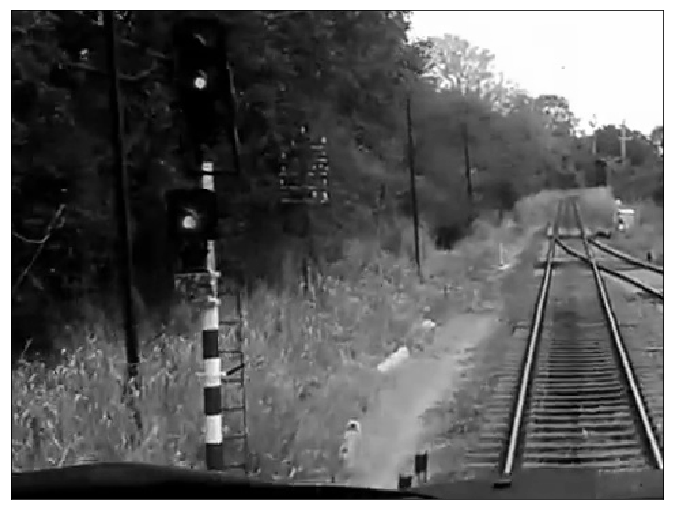

In [36]:
gray = cv.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
show_gimage(gray)


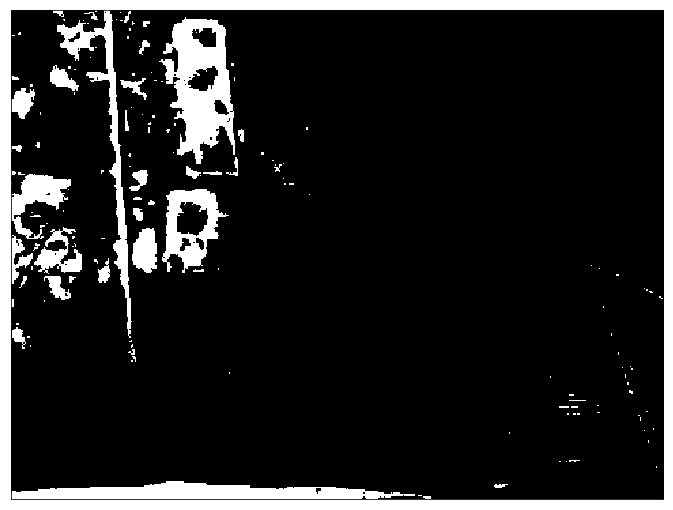

In [37]:
ret, gb = cv.threshold(gray,6,255,cv2.THRESH_BINARY_INV)

#gb = cv.bitwise_not(gb)
show_gimage(gb)

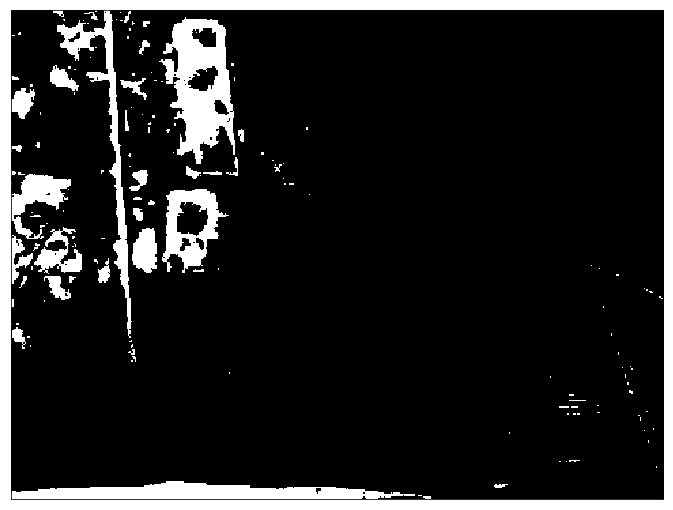

In [38]:
kernel = np.ones((1,1),np.uint8)
erosion = cv.erode(gb,kernel,iterations = 2)
show_gimage(erosion)

In [39]:
def draw_large_contour(img, org):
    output = org.copy()
    contours,hierachy = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    print(len(contours))
    if len(contours) != 0:
        #cv.drawContours(output, contours, -1, (0,255,0), 3)
        print('hi')
        c = max(contours, key = cv.contourArea)
        areaArray = []
        for i, c in enumerate(contours):
            area = cv2.contourArea(c)
            areaArray.append(area)

        #first sort the array by area
        sorteddata = sorted(zip(areaArray, contours), key=lambda x: x[0], reverse=True)
        
        first = sorteddata[0][1]
        
        #find the nth largest contour [n-1][1], in this case 2
        second = sorteddata[2][1]
        
        x,y,w,h = cv.boundingRect(first)
        cv.rectangle(output, (x,y), (x+w, y+h), (0,255,0),2)
        
        x,y,w,h = cv.boundingRect(second)
        cv.rectangle(output, (x,y), (x+w, y+h), (0,255,0),2)
        
    return output

152
hi


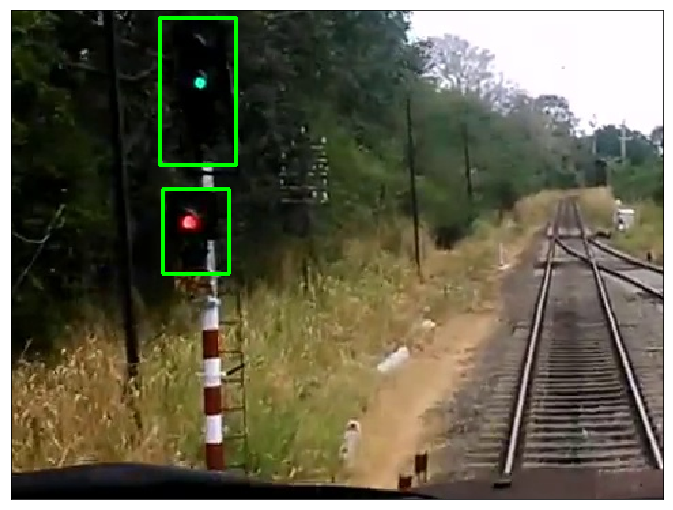

In [40]:
ct = draw_large_contour(gb, cropped_img)
show_image(ct)